# **Import Lib**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

sns.set(style="whitegrid")

# ***Upload***

In [2]:
from google.colab import files
uploaded = files.upload()

Saving combined_datasett.csv to combined_datasett (1).csv


In [3]:
df = pd.read_csv('combined_datasett.csv')

In [5]:
print(df.columns)

print(df.info())

Index(['text', 'source', 'label'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17263 entries, 0 to 17262
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17255 non-null  object
 1   source  17263 non-null  object
 2   label   17263 non-null  object
dtypes: object(3)
memory usage: 404.7+ KB
None


# **Cleaning**

In [7]:
label_map = {
    'positif': 'positif',
    'negatif': 'negatif',
    'netral': 'netral',
    '0': 'netral',
    '1': 'positif',
    '-1': 'negatif',
    0: 'netral',
    1: 'positif',
    -1: 'negatif'
}
df['label'] = df['label'].astype(str).str.lower().map(label_map)
df = df[df['label'].isin(['positif', 'negatif', 'netral'])]

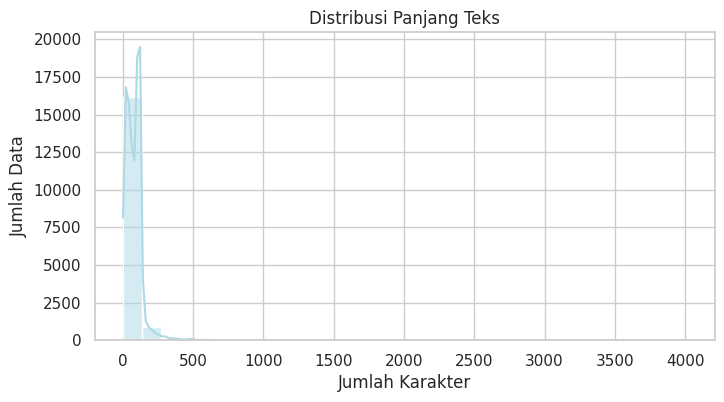

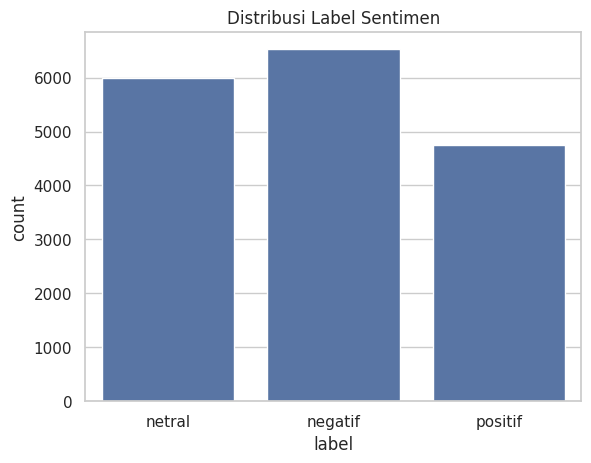

In [9]:
#Analisis text

df['text_length'] = df['text'].astype(str).apply(len)

plt.figure(figsize=(8,4))
sns.histplot(df['text_length'], bins=30, kde=True, color='lightblue')
plt.title('Distribusi Panjang Teks')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Jumlah Data')
plt.show()

sns.countplot(data=df, x='label')
plt.title('Distribusi Label Sentimen')
plt.show()

# **Clean text**

In [10]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)

# **Encode**

In [11]:
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])  # 0=negatif, 1=netral, 2=positif
print("Classes:", le.classes_)

Classes: ['negatif' 'netral' 'positif']


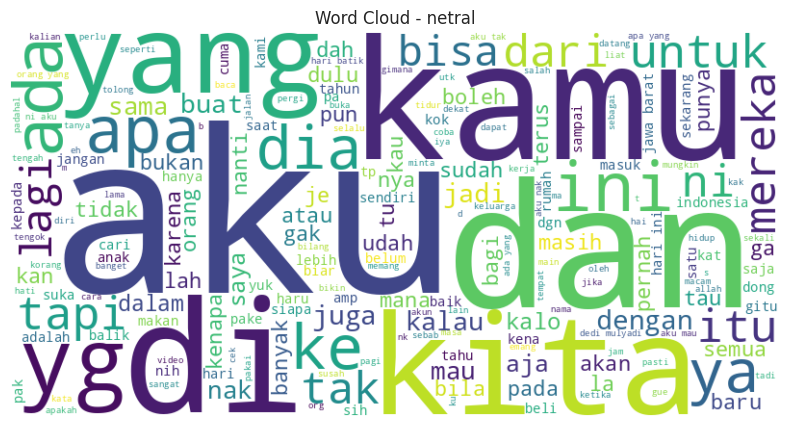

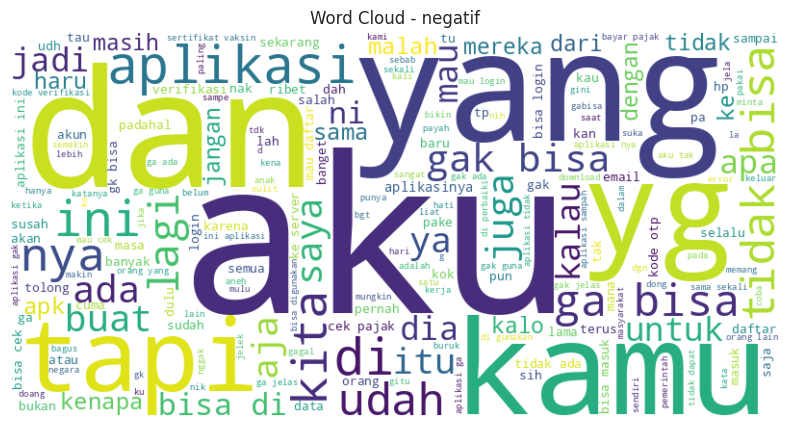

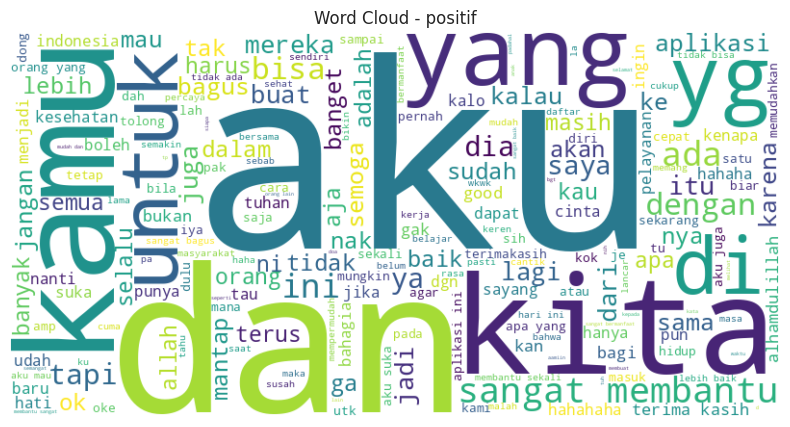

In [12]:
from wordcloud import WordCloud
for label in df['label'].unique():
    text = " ".join(df[df['label'] == label]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {label}")
    plt.show()

# **Tokenisasi**

In [13]:
vocab_size = 10000
embedding_dim = 128
max_length = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_text'])

In [14]:
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

X = padded_sequences
y = df['label_enc'].values

# **Split data**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.8818646232439336), 1: np.float64(0.9596275449933986), 2: np.float64(1.213639159855875)}


# **Model**

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.models import Model

inputs = Input(shape=(max_length,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.4)(x)
x = Bidirectional(LSTM(32, kernel_regularizer=l2(0.02)))(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.02))(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# CALLBACKS
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,422,211 (5.43 MB)

 Trainable params: 1,422,211 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 154s 739ms/step - accuracy: 0.3864 - loss: 5.0773 - val_accuracy: 0.6314 - val_loss: 1.7257 - learning_rate: 5.0000e-04
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 193s 698ms/step - accuracy: 0.6509 - loss: 1.3996 - val_accuracy: 0.6799 - val_loss: 0.9148 - learning_rate: 5.0000e-04
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 142s 699ms/step - accuracy: 0.7593 - loss: 0.7657 - val_accuracy: 0.6988 - val_loss: 0.8098 - learning_rate: 5.0000e-04
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 143s 703ms/step - accuracy: 0.8195 - loss: 0.5803 - val_accuracy: 0.6879 - val_loss: 0.8050 - learning_rate: 5.0000e-04
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 142s 706ms/step - accuracy: 0.8226 - loss: 0.5902 - val_accuracy: 0.6959 - val_loss: 0.8252 - learning_rate: 5.0000e-04
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.8649 - loss: 0.4567
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
195/195 ━━━━━━━━━━━━━━━━━━━━ 136s 69

Evaluasi

In [19]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Akurasi Test: {acc:.4f}, Loss: {loss:.4f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.6846 - loss: 1.0343
Akurasi Test: 0.6797, Loss: 1.0266


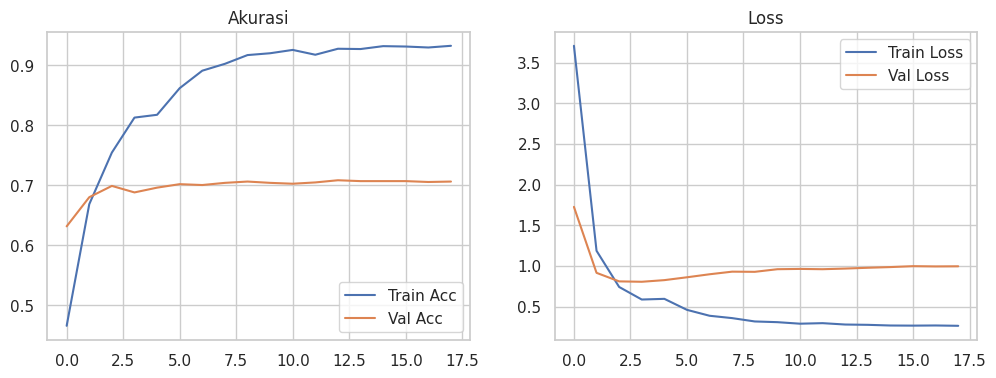

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Akurasi')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

Confusion Matrix

In [23]:
# Prediksi
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# test
y_true = y_test

# Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_true, y_pred_classes, digits=4))

108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step
              precision    recall  f1-score   support

           0     0.7296    0.7402    0.7349      1305
           1     0.6199    0.6483    0.6338      1200
           2     0.6899    0.6361    0.6619       948

    accuracy                         0.6797      3453
   macro avg     0.6798    0.6749    0.6769      3453
weighted avg     0.6806    0.6797    0.6797      3453



Simpan Model

In [25]:
# Simpan model
model.save('model_sentimen.keras')

# Simpan tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [31]:
def prediksi_sentimen(teks):
    seq = tokenizer.texts_to_sequences([teks])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    pred = model.predict(padded)
    label_index = np.argmax(pred, axis=1)[0]
    skor = pred[0]
    label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}
    label = label_map[label_index]
    return label, skor

contoh = "Pelayanan publik sangat lambat dan mengecewakan."
label, skor = prediksi_sentimen(contoh)

confidence = float(np.max(skor))
output_deskriptif = f"""
Model memprediksi bahwa kalimat:
"{contoh}"
termasuk dalam sentimen *{label}* dengan tingkat kepercayaan sebesar {confidence*100:.1f}%.
Hal ini menunjukkan bahwa pengguna kemungkinan merasa {'puas' if label == 'positif' else 'tidak puas' if label == 'negatif' else 'netral'} terhadap isi kalimat tersebut.
"""
print(output_deskriptif)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step

Model memprediksi bahwa kalimat:
"Pelayanan publik sangat lambat dan mengecewakan."
termasuk dalam sentimen *negatif* dengan tingkat kepercayaan sebesar 53.8%.
Hal ini menunjukkan bahwa pengguna kemungkinan merasa tidak puas terhadap isi kalimat tersebut.



In [32]:
print("="*80)
print("HASIL ANALISIS SENTIMEN")
print("="*80)
print(f"Teks Ulasan     : {contoh}")
print(f"Prediksi Sentimen : {label.upper()} ({np.max(skor)*100:.2f}% confidence)")
print(f"Probabilitas Kelas: Negatif = {skor[0]:.2f}, Netral = {skor[1]:.2f}, Positif = {skor[2]:.2f}")
print("="*80)

HASIL ANALISIS SENTIMEN
Teks Ulasan     : Pelayanan publik sangat lambat dan mengecewakan.
Prediksi Sentimen : NEGATIF (53.84% confidence)
Probabilitas Kelas: Negatif = 0.54, Netral = 0.27, Positif = 0.19


In [33]:
ulasan = [
    "Pelayanan publik sangat lambat dan mengecewakan.",
    "Saya senang dengan pembangunan infrastruktur yang cepat.",
    "Acara tersebut biasa saja, tidak terlalu istimewa."
]

for teks in ulasan:
    label, skor = prediksi_sentimen(teks)
    print(f"Teks : {teks}")
    print(f"→ Sentimen: {label} ({np.max(skor)*100:.1f}%)\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Teks : Pelayanan publik sangat lambat dan mengecewakan.
→ Sentimen: negatif (53.8%)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Teks : Saya senang dengan pembangunan infrastruktur yang cepat.
→ Sentimen: positif (97.6%)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Teks : Acara tersebut biasa saja, tidak terlalu istimewa.
→ Sentimen: netral (95.4%)

